# Primera version de la matriz de insumo producto


In [156]:
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [157]:
# Descargar matriz insumo-producto del INEGI
# https://www.inegi.org.mx/programas/mip/2018/#datos_abiertos

dir_arch = 'mip_csv/conjunto_de_datos/conjunto_de_datos_mip_cdi_ixi_12018.csv' # descargo la inversa de Leontief
L = pd.read_csv(dir_arch, index_col=0)

# Seleccionar sector para choque de demanda
sectores = L.index
print("\nSectores disponibles:")
for i, sector in enumerate(sectores):
    print(f"{i}: {sector}")


Sectores disponibles:
0: 11---Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza
1: 21---Minería
2: 22---Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final
3: 23---Construcción
4: 31-33---Industrias manufactureras
5: 43---Comercio al por mayor
6: 46---Comercio al por menor
7: 48-49---Transportes, correos y almacenamiento
8: 51---Información en medios masivos
9: 52---Servicios financieros y de seguros
10: 53---Servicios inmobiliarios y de alquiler de bienes muebles e intangibles
11: 54---Servicios profesionales, científicos y técnicos
12: 55---Corporativos
13: 56---Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación
14: 61---Servicios educativos
15: 62---Servicios de salud y de asistencia social
16: 71---Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos
17: 72---Servicios de alojamiento temporal y 

In [158]:
#sector_idx = int(input("\nIngrese el índice del sector: "))
#aumento_demanda = float(input("Ingrese el aumento en demanda (millones de pesos): "))
sector_idx = 3  # Ejemplo: Construcción
aumento_demanda = 10000.0  # Ejemplo: 10,000 millones de pesos 


print(f"\nSector seleccionado: {sectores[sector_idx]}")


Sector seleccionado: 23---Construcción


In [159]:
delta_demanda = np.zeros(len(sectores))
delta_demanda[sector_idx] = aumento_demanda

# Calcular impacto total en producción
impacto_produccion = L @ delta_demanda 


# Mostrar resultados
resultados = pd.DataFrame({
    'Sector': sectores,
    'Impacto en Producción': impacto_produccion
}).sort_values('Impacto en Producción', ascending=False)

print(f"\n{'='*80}")
print(f"IMPACTO DE AUMENTO EN DEMANDA: ${aumento_demanda:,.0f} millones")
print(f"Sector: {sectores[sector_idx]}")
print(f"{'='*80}")
print(f"\nTop 10 sectores más impactados:")
print(resultados.head(10).to_string(index=False))
print(f"\nImpacto total en la economía: ${impacto_produccion.sum():,.2f} millones")
print(f"Multiplicador: {impacto_produccion.sum()/aumento_demanda:.2f}")



IMPACTO DE AUMENTO EN DEMANDA: $10,000 millones
Sector: 23---Construcción

Top 10 sectores más impactados:
                                                                                  Sector  Impacto en Producción
                                                                       23---Construcción           11163.973369
                                                       31-33---Industrias manufactureras            2565.543346
                                                              43---Comercio al por mayor             523.256937
                                                              46---Comercio al por menor             519.611194
                                                                            21---Minería             279.164638
                                    54---Servicios profesionales, científicos y técnicos             202.930609
                                           48-49---Transportes, correos y almacenamiento             198.384

In [160]:
# Guardar resultados
resultados.to_csv('impacto_demanda.csv', index=False)
print("\nResultados guardados en 'impacto_demanda.csv'")


Resultados guardados en 'impacto_demanda.csv'


Gráficas guardadas en 'impacto_demanda.png'


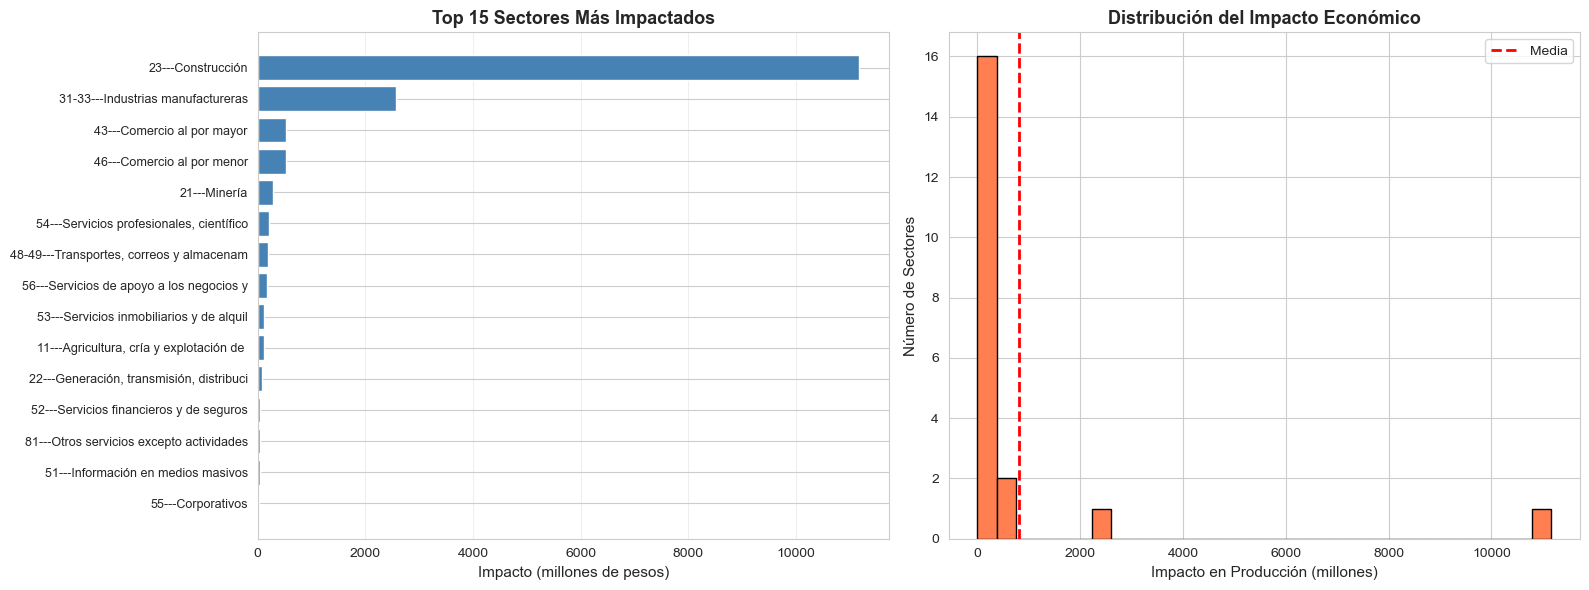

In [161]:
# Gráficas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Top 15 sectores más impactados
top15 = resultados.head(15)
axes[0].barh(range(len(top15)), top15['Impacto en Producción'], color='steelblue')
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels([s[:40] for s in top15['Sector']], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Impacto (millones de pesos)', fontsize=11)
axes[0].set_title('Top 15 Sectores Más Impactados', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Gráfica 2: Distribución del impacto
impactos_positivos = resultados[resultados['Impacto en Producción'] > 0.01]
axes[1].hist(impactos_positivos['Impacto en Producción'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Impacto en Producción (millones)', fontsize=11)
axes[1].set_ylabel('Número de Sectores', fontsize=11)
axes[1].set_title('Distribución del Impacto Económico', fontsize=13, fontweight='bold')
axes[1].axvline(impactos_positivos['Impacto en Producción'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Media')
axes[1].legend()

plt.tight_layout()
plt.savefig('impacto_demanda.png', dpi=300, bbox_inches='tight')
print("Gráficas guardadas en 'impacto_demanda.png'")
plt.show()


# La copa del mundo 2026

In [162]:
# 1. Cargar Matriz doméstica ixi
dir_arch = 'mip_csv/conjunto_de_datos/conjunto_de_datos_mip_cdi_ixi_22018.csv' # las cifras estan en millones de pesos

L = pd.read_csv(dir_arch, index_col=0) 
sectores = L.index

L #impresion


,111---Agricultura,112---Cría y explotación de animales,113---Aprovechamiento forestal,"114---Pesca, caza y captura",115---Servicios relacionados con las actividades agropecuarias y forestales,211---Extracción de petróleo y gas,"212---Minería de minerales metálicos y no metálicos, excepto petróleo y gas",213---Servicios relacionados con la minería,"221---Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final",236---Edificación,...,"711---Servicios artísticos, culturales y deportivos, y otros servicios relacionados","712---Museos, sitios históricos, zoológicos y similares",713---Servicios de entretenimiento en instalaciones recreativas y otros servicios recreativos,721---Servicios de alojamiento temporal,722---Servicios de preparación de alimentos y bebidas,811---Servicios de reparación y mantenimiento,812---Servicios personales,813---Asociaciones y organizaciones,814---Hogares con empleados domésticos,"931---Actividades legislativas, gubernamentales y de impartición de justicia"
Descriptores,,,,,,,,,,,,,,,,,,,,,
111---Agricultura,1.020852,0.142277,6.804733e-03,0.014449,0.031313,0.000408,0.000463,0.000511,0.000126,0.000366,...,1.780547e-03,0.001408,0.002790,0.031016,5.240144e-02,7.365518e-04,1.348292e-03,0.007055,0,0.001911
112---Cría y explotación de animales,0.008131,1.062227,1.607010e-04,0.021915,0.000542,0.000194,0.000180,0.000322,0.000093,0.000466,...,1.194849e-03,0.001320,0.002758,0.004961,1.571559e-02,2.435246e-04,7.947083e-04,0.006064,0,0.001616
113---Aprovechamiento forestal,0.000353,0.000229,1.045935e+00,0.000436,0.000512,0.000293,0.008139,0.000693,0.000222,0.002175,...,1.899669e-04,0.000372,0.000423,0.000309,9.187103e-04,3.657507e-04,2.085943e-04,0.000236,0,0.000159
"114---Pesca, caza y captura",0.000006,0.000512,3.795931e-06,1.001007,0.000007,0.000013,0.000004,0.000035,0.000003,0.000007,...,1.879810e-05,0.000058,0.000041,0.001687,1.259283e-03,6.023836e-06,1.335651e-05,0.000091,0,0.000042
115---Servicios relacionados con las actividades agropecuarias y forestales,0.005790,0.002802,2.848584e-03,0.001215,1.000211,0.000008,0.000029,0.000011,0.000003,0.000016,...,4.039074e-05,0.000047,0.000087,0.000260,4.735667e-04,3.187042e-05,5.105827e-05,0.000140,0,0.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811---Servicios de reparación y mantenimiento,0.001642,0.001873,1.507770e-03,0.007256,0.004138,0.029254,0.010045,0.005653,0.009504,0.003441,...,9.242084e-04,0.014765,0.004036,0.001998,1.033826e-03,1.003525e+00,1.823255e-03,0.001856,0,0.012748
812---Servicios personales,0.000026,0.000111,2.231672e-05,0.000143,0.000073,0.000053,0.000042,0.000094,0.000027,0.000069,...,6.235533e-05,0.000608,0.000379,0.000771,1.197323e-04,9.669167e-05,1.000209e+00,0.000987,0,0.001568
813---Asociaciones y organizaciones,0.000055,0.000077,4.333032e-04,0.000745,0.000459,0.000122,0.000067,0.000190,0.000075,0.000202,...,8.689922e-03,0.000076,0.000087,0.000660,4.671148e-05,2.324334e-04,6.398636e-05,1.000103,0,0.000075


In [163]:
# 2. Crear el Vector de Shock (Todo en ceros al principio)
# El tamaño debe ser igual al número de sectores en la matriz (filas)

n_sectores = L.shape[0]
shock_mundial = np.zeros(n_sectores)

In [164]:
# 3. Definir el monto total (en millones de pesos, si la matriz está en millones)
monto_total = 4641 # millones
distribucion = {
    '721': 0.35, # Servicios de Alojamoiento temporal
    '722': 0.25, # Servicios de preparación de comida
    '485': 0.15, # Transporte Terrestre
    '461': 0.10, # Comercio al pormenor
    '711': 0.15  # Entretenimiento
}

In [165]:
# 4. Asignar los montos a los índices correspondientes
for sec in distribucion:
    for i in range(len(L.index)):
        if L.index[i].startswith(sec):
            shock_mundial[i] = monto_total * distribucion[sec]

shock_mundial

array([   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,  464.1 ,
          0.  ,    0.  ,    0.  ,    0.  ,  696.15,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,  696.15,    0.  ,
          0.  , 1624.35, 1160.25,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ])

In [166]:
# 5. Calcular Impacto
impacto_produccion = L @ shock_mundial

print(f"Impacto Directo (Gasto Turistas): ${monto_total} M")
print(f"Impacto Total en la Economía Mexicana: ${np.sum(impacto_produccion):.2f} M")

Impacto Directo (Gasto Turistas): $4641 M
Impacto Total en la Economía Mexicana: $6332.27 M


In [167]:
# --- IMP ---- ya tengo la variable impacto de produccion de la celda anterior

# Mostrar resultados
resultados = pd.DataFrame({
    'Sector': sectores,
    'Impacto en Producción': impacto_produccion
}).sort_values('Impacto en Producción', ascending=False)

print(f"\n{'='*80}")
print(f"IMPACTO DE AUMENTO EN DEMANDA POR EL MUNDIAL: ${monto_total:,.0f} millones")
print(f"Sectores: {distribucion.keys()}")
print(f"{'='*80}")
print(f"\nTop 10 sectores más impactados:")
print(resultados.head(10).to_string(index=False))
print(f"\nImpacto total en la economía: ${impacto_produccion.sum():,.2f} millones")
print(f"Multiplicador: {impacto_produccion.sum()/aumento_demanda:.2f}") ## falla, tengo que corregir



IMPACTO DE AUMENTO EN DEMANDA POR EL MUNDIAL: $4,641 millones
Sectores: dict_keys(['721', '722', '485', '461', '711'])

Top 10 sectores más impactados:
                                                                             Sector  Impacto en Producción
                                            721---Servicios de alojamiento temporal            1625.689904
                              722---Servicios de preparación de alimentos y bebidas            1163.308644
                   485---Transporte terrestre de pasajeros, excepto por ferrocarril             697.809478
711---Servicios artísticos, culturales y deportivos, y otros servicios relacionados             696.186030
       461---Comercio al por menor de abarrotes, alimentos, bebidas, hielo y tabaco             557.631367
                                            561---Servicios de apoyo a los negocios             230.839250
                                                        311---Industria alimentaria             15

Gráficas guardadas en 'Mundial.png'


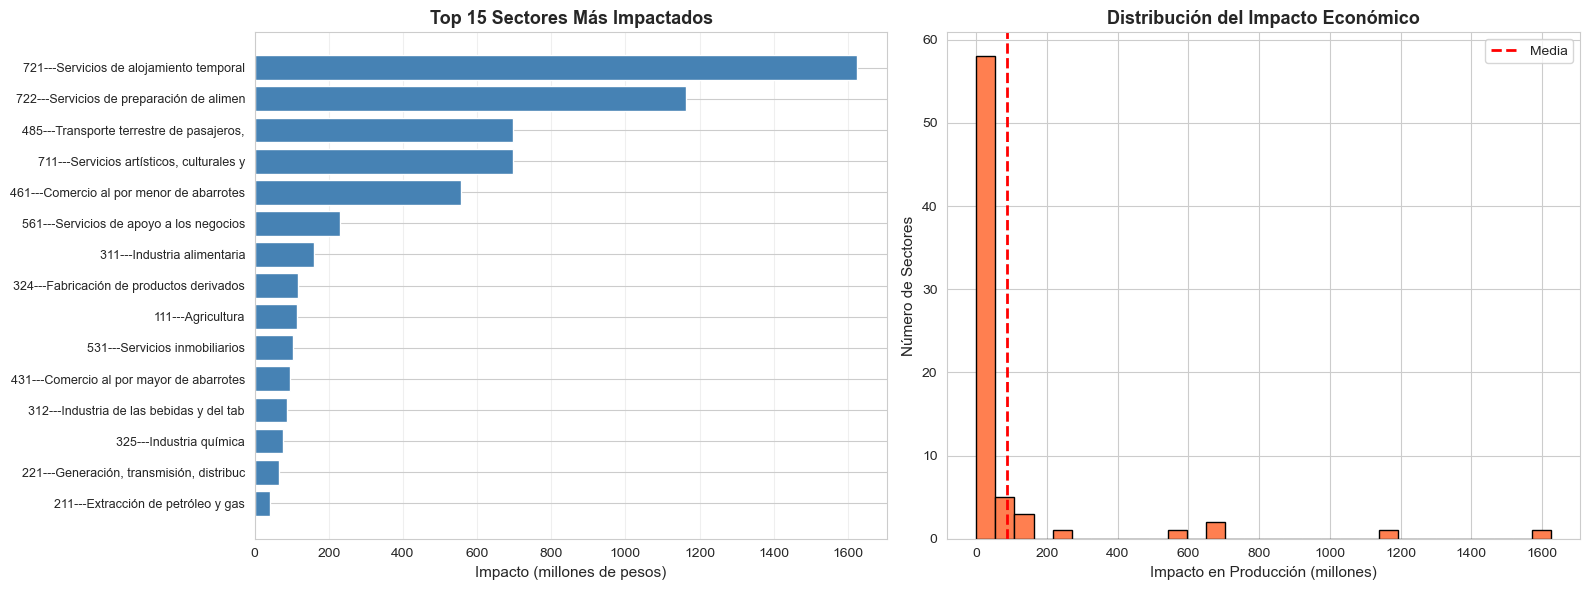

In [168]:
# Gráficas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Top 15 sectores más impactados
top15 = resultados.head(15)
axes[0].barh(range(len(top15)), top15['Impacto en Producción'], color='steelblue')
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels([s[:40] for s in top15['Sector']], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Impacto (millones de pesos)', fontsize=11)
axes[0].set_title('Top 15 Sectores Más Impactados', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Gráfica 2: Distribución del impacto
impactos_positivos = resultados[resultados['Impacto en Producción'] > 0.01]
axes[1].hist(impactos_positivos['Impacto en Producción'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Impacto en Producción (millones)', fontsize=11)
axes[1].set_ylabel('Número de Sectores', fontsize=11)
axes[1].set_title('Distribución del Impacto Económico', fontsize=13, fontweight='bold')
axes[1].axvline(impactos_positivos['Impacto en Producción'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Media')
axes[1].legend()

plt.tight_layout()
plt.savefig('Mundial.png', dpi=300, bbox_inches='tight')
print("Gráficas guardadas en 'Mundial.png'")
plt.show()


# Carros electricos vs Carros de gasolina

In [ ]:
#generamos nuestro nuevo vector de choque
shock_mundial = np.zeros(n_sectores)

monto_elect = 306 # millones
monto_gasolina = -535 # millones
monto_excedente = -(monto_elect + monto_gasolina)

print(f"Monto excedente a distribuir: {monto_excedente} millones")

distribucion = {
    '221': monto_elect, # Generación de energía eléctrica
    '324': monto_gasolina, # Generacion de gasolina

    # espacio para colocar las otras variables
    
}

Monto excedente a distribuir: 229 millones


In [170]:
# 4. Asignar los montos a los índices correspondientes
for sec in distribucion:
    for i in range(len(L.index)):
        if L.index[i].startswith(sec):
            if abs(distribucion[sec]) > 1 :
                shock_mundial[i] = distribucion[sec]
            else:
                shock_mundial[i] = monto_excedente * distribucion[sec]

shock_mundial

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  306.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0., -535.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  229.,
          0.,    0.,    0.,    0.,    0.,    0.])

In [171]:
# 5. Calcular Impacto
impacto_produccion = L @ shock_mundial

print(f"Impacto Total en la Economía Mexicana: ${np.sum(impacto_produccion):.2f} M")

Impacto Total en la Economía Mexicana: $-108.82 M


In [172]:
# --- IMP ---- ya tengo la variable impacto de produccion de la celda anterior

# Mostrar resultados
resultados = pd.DataFrame({
    'Sector': sectores,
    'Impacto en Producción': impacto_produccion
}).sort_values('Impacto en Producción', ascending=False)

print(f"\n{'='*80}")
print(f"IMPACTO DE AUMENTO EN DEMANDA POR EL MUNDIAL: ${monto_total:,.0f} millones")
print(f"Sectores: {distribucion.keys()}")
print(f"{'='*80}")
print(f"\nTop 10 sectores más impactados:")
print(resultados.head(10).to_string(index=False))
print(f"\nImpacto total en la economía: ${impacto_produccion.sum():,.2f} millones")
print(f"Multiplicador: {impacto_produccion.sum()/aumento_demanda:.2f}")


IMPACTO DE AUMENTO EN DEMANDA POR EL MUNDIAL: $4,641 millones
Sectores: dict_keys(['221', '324', '721'])

Top 10 sectores más impactados:
                                                                                                                                                 Sector  Impacto en Producción
221---Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final             308.206138
                                                                                                                721---Servicios de alojamiento temporal             228.128713
                                                                                                                561---Servicios de apoyo a los negocios              16.570687
                                                                                                                                      111---Agricultura          

Gráficas guardadas en 'Top.png'


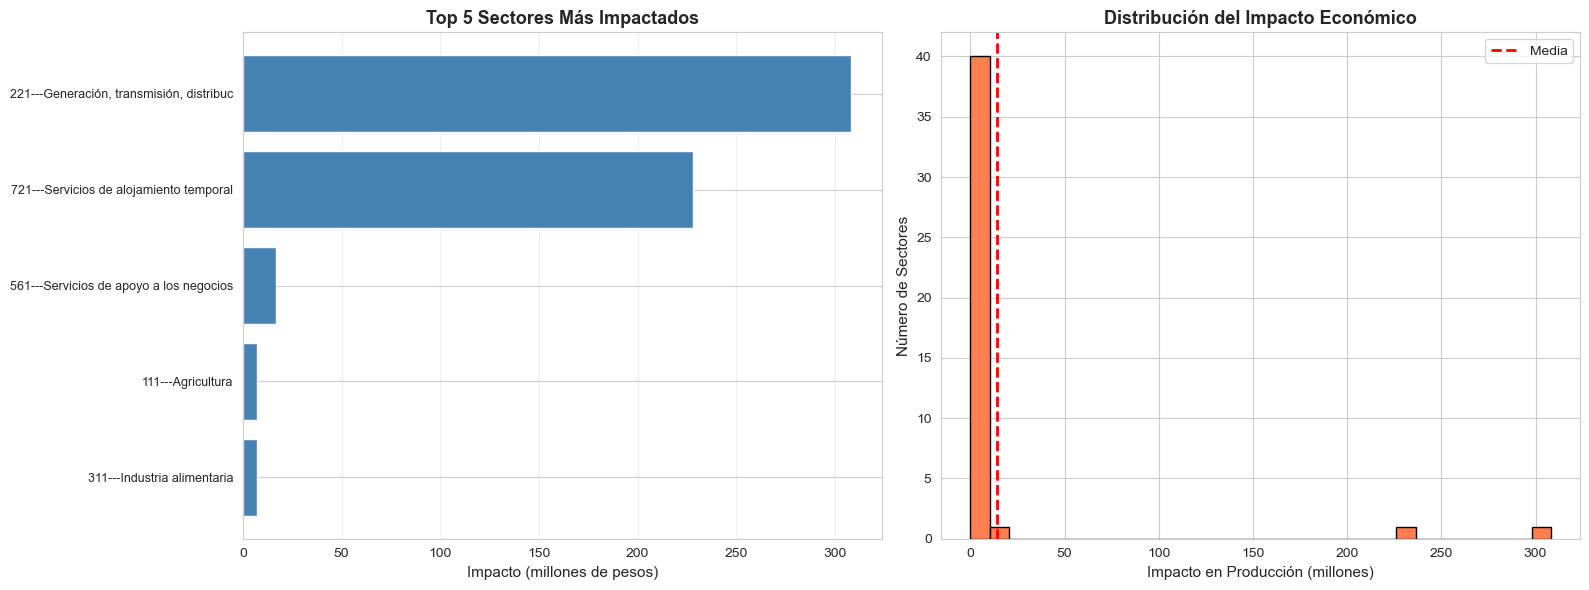

In [173]:
# Gráficas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Top 5 sectores más impactados
top15 = resultados.head(5)
axes[0].barh(range(len(top15)), top15['Impacto en Producción'], color='steelblue')
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels([s[:40] for s in top15['Sector']], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Impacto (millones de pesos)', fontsize=11)
axes[0].set_title('Top 5 Sectores Más Impactados', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Gráfica 2: Distribución del impacto
impactos_positivos = resultados[resultados['Impacto en Producción'] > 0.01]
axes[1].hist(impactos_positivos['Impacto en Producción'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Impacto en Producción (millones)', fontsize=11)
axes[1].set_ylabel('Número de Sectores', fontsize=11)
axes[1].set_title('Distribución del Impacto Económico', fontsize=13, fontweight='bold')
axes[1].axvline(impactos_positivos['Impacto en Producción'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Media')
axes[1].legend()

plt.tight_layout()
plt.savefig('Top.png', dpi=300, bbox_inches='tight')
print("Gráficas guardadas en 'Top.png'")
plt.show()

Gráficas guardadas en 'Bottom.png'


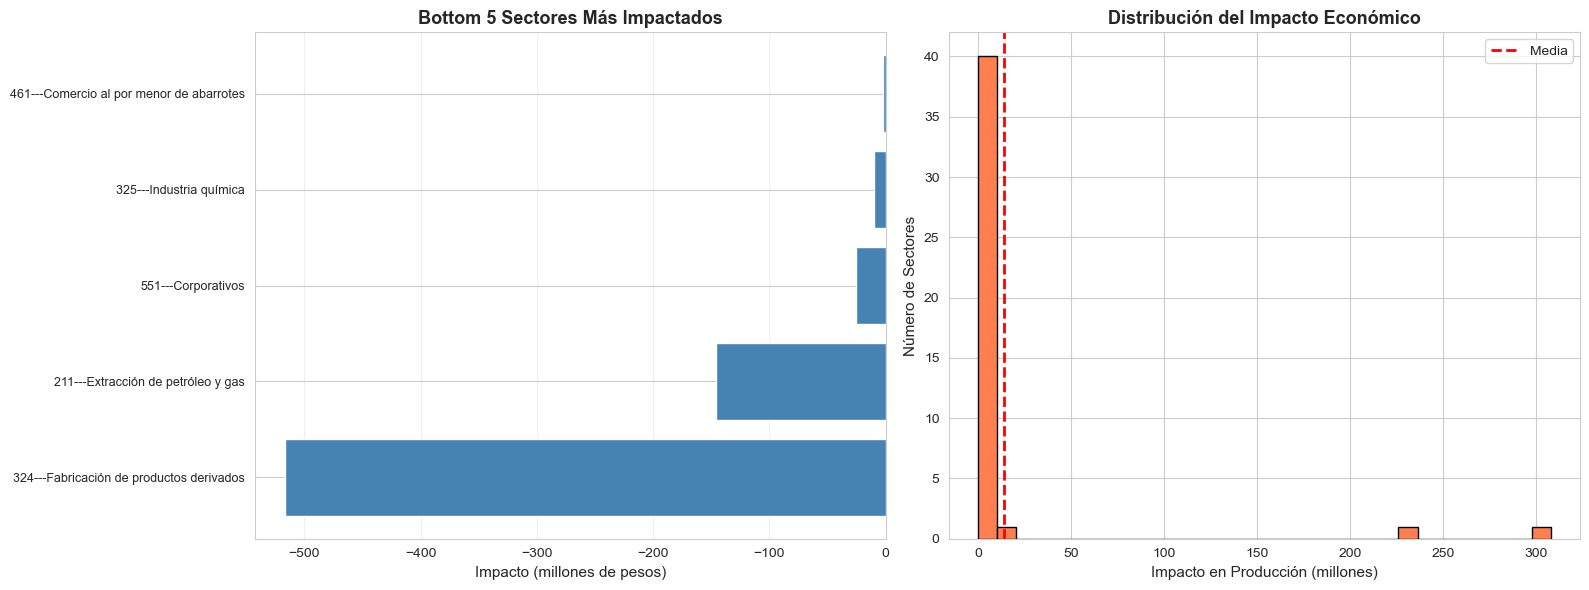

In [174]:
# Gráficas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Bottom 5 sectores más impactados
top15 = resultados.tail(5)
axes[0].barh(range(len(top15)), top15['Impacto en Producción'], color='steelblue')
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels([s[:40] for s in top15['Sector']], fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Impacto (millones de pesos)', fontsize=11)
axes[0].set_title('Bottom 5 Sectores Más Impactados', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Gráfica 2: Distribución del impacto
impactos_positivos = resultados[resultados['Impacto en Producción'] > 0.01]
axes[1].hist(impactos_positivos['Impacto en Producción'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Impacto en Producción (millones)', fontsize=11)
axes[1].set_ylabel('Número de Sectores', fontsize=11)
axes[1].set_title('Distribución del Impacto Económico', fontsize=13, fontweight='bold')
axes[1].axvline(impactos_positivos['Impacto en Producción'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Media')
axes[1].legend()

plt.tight_layout()
plt.savefig('Bottom.png', dpi=300, bbox_inches='tight')
print("Gráficas guardadas en 'Bottom.png'")
plt.show()